In [38]:
# required packages

import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# plot styling preferences
plt.style.use("seaborn-whitegrid")
font = {"family": "Helvetica",
"weight": "bold",
"size": 14}

mpl.rc("font", **font)


/var/folders/r9/ggpr596s74x4hr8c_sfdzc580000gn/T/ipykernel_13843/2696075094.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# Step 01: Calculate required sample size

This is done via the Power Analysis.
We currently have a conversion rate of 13%; the team decides that a value of 15% is enough. Therefore, we can use a 2% value for the beta (in the equation, we use 1 - beta).

In [39]:
effect_size = sms.proportion_effectsize(0.13, 0.15)

sample_size = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8, # 1- beta, which is 0.2
    alpha=0.05, # significance level
    ratio=1 # # Ratio of sample sizes of the two groups (n2/n1) so here both groups have the same size
)

required_n = ceil(sample_size) # rounds value to next integer

print(f"The required sample size is {required_n}.")

The required sample size is 4720.


# Step 02: Collect and prepare the data

In [40]:
# read the data

df = pd.read_csv("../data/ab_test.csv")

df.head() # check first 5 rows


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [41]:
df.info() # info about DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [42]:
# contigency table to check if the control entries are seeing the old page, 
# while the the treatment sees the new page
pd.crosstab(df["group"], df["landing_page"])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Since from the table above, we see that some values are not correct (people in the control group need to see the old page only), we will filter these cases out.

In [43]:
df = df.query('(group == "control" & landing_page == "old_page") | (group=="treatment"& landing_page=="new_page")')

# then we check again
pd.crosstab(df["group"], df["landing_page"])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


Before we proceed, we will make sure that no user has been counted multiple times, by checking their user_id.

In [44]:
session_counts = df["user_id"].value_counts()
multiple_sessions = session_counts[session_counts>1].count()

print(f"There are {multiple_sessions} users with multiple sessions in the dataset.")

# we proceed by removing users with multiple sessions, if any

if multiple_sessions > 0:
    users_to_drop = session_counts[session_counts>1].index
    df = df[~df["user_id"].isin(users_to_drop)]
    print(f"The dataset was updated. It has now a total of {df.shape[0]} entries")

There are 1 users with multiple sessions in the dataset.
The dataset was updated. It has now a total of 290583 entries


# Step 03: Sampling

The function .sample from pandas returns a simple random sampling

In [45]:
control_sample = df[df["group"] == "control"].sample(n=required_n) # note, you can use random_state to get reproducible results
test_sample = df[df["group"]=="treatment"].sample(n=required_n)

ab_test = pd.concat([control_sample, test_sample])

ab_test.head()

,user_id,timestamp,group,landing_page,converted
127223,932702,2017-01-14 22:42:39.287750,control,old_page,0
102638,678792,2017-01-05 21:25:35.467148,control,old_page,0
157334,879494,2017-01-10 05:34:52.740212,control,old_page,0
49435,941787,2017-01-15 05:51:39.013184,control,old_page,0
45681,841134,2017-01-19 21:57:19.666448,control,old_page,0


In [46]:
# checks if all went well, the sample size is the same in both groups
ab_test["group"].value_counts()

group
control      4720
treatment    4720
Name: count, dtype: int64

# Step 04: Compute and visualise the results

In [47]:
# basic statistics
conversion_rates = ab_test.groupby('group')['converted'].agg(
    conversion_rate='mean',
    std_deviation=lambda x: np.std(x, ddof=0), # Std. deviation of the proportion
    std_error=lambda x: stats.sem(x, ddof=0) # Std. error of the proportion (std / sqrt(n))
)

# Display the table with formatted values
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.116,0.320,0.005
treatment,0.113,0.316,0.005


We can see that the convertion rate of the groups is very similar. We can plot a graph that will help to visualise this better.

/var/folders/r9/ggpr596s74x4hr8c_sfdzc580000gn/T/ipykernel_13843/512634752.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ab_test["group"], y=ab_test["converted"], palette=["purple", "pink"])


(0.0, 0.15)

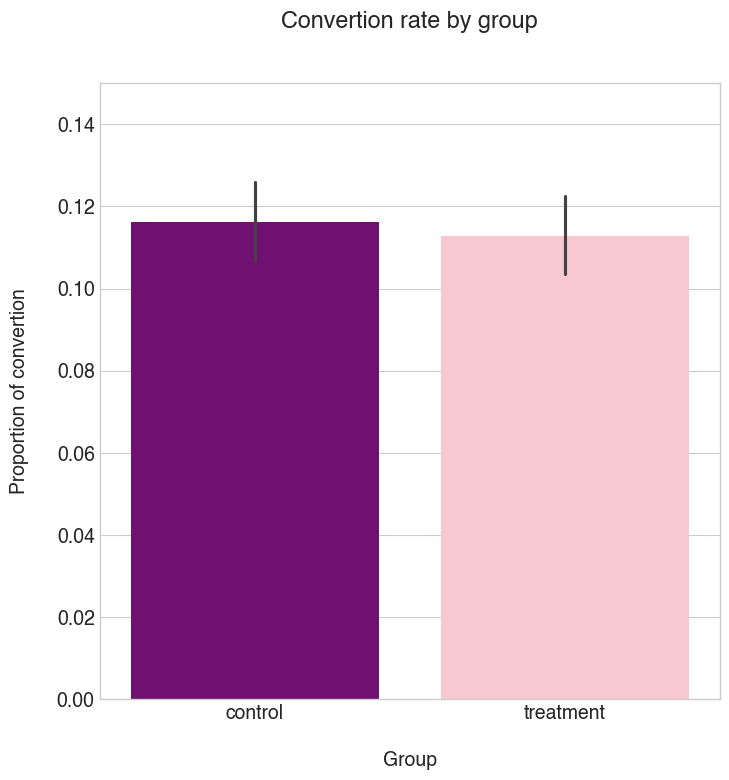

In [48]:
plt.figure(figsize=(8, 8))
sns.barplot(x=ab_test["group"], y=ab_test["converted"], palette=["purple", "pink"])

plt.title("Convertion rate by group", pad=40)
plt.xlabel("Group", labelpad=20) # ps: pad refers to distance
plt.ylabel("Proportion of convertion", labelpad=20)
plt.ylim(0, .15) # ylim says up to which value the axis goes

# Step 05: Testing the hypothesis

In [51]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

# count entries in each group
n_control = control_results.count()
n_experiment = treatment_results.count()

# sum sucesses in each group
successes = [control_results.sum(), treatment_results.sum()]

# number of observations in each group
nobs = [n_control, n_experiment]

# performs Z-test for proportions
z_stat, pval = proportions_ztest(successes, nobs=nobs)

# calculating confidence intervals
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

# print results
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')



z statistic: 0.48
p-value: 0.628
ci 95% for control group: [0.107, 0.125]
ci 95% for treatment group: [0.104, 0.122]


Since the p-value is higher than alpha (0.05), we cannot reject the null hypothesis, and the results have to significant difference.

If we look at the confidence interval for the treatment group ([0.104, 0.122], i.e. 10.4-12.2%) we notice that:

- It does not includes our baseline value of 13% conversion rate
- It does not include our target value of 15% (the 2% uplift we were aiming for)